# Анализ бизнес-показателей развлекательного приложения

**Описание проекта**

Для развлекательного приложения необходимо выявить причины неокпаемости вложений в рекламу и  убытков последних месяцев, а также помочь компании выйти в плюс.

**План исследования:**

* [Изучение общей информации о данных и предобработка](#chapter1)
* [Функции для расчёта и анализа LTV, ROI, удержания и конверсии](#chapter2)
    * [ Функция get_profiles() — для создания профилей пользователей](#section_2_1)
    * [Функция get_retention() — для подсчёта Retention Rate](#section_2_2)
    * [ Функция get_conversion() — для подсчёта конверсиий](#section_2_3)
    * [Функция get_ltv() — для подсчёта LTV](#section_2_4)
    * [ Функция filter_data() — для сглаживания данных](#section_2_5)
    * [ Функция plot_retention() — для построения графика Retention Rate](#section_2_6)
    * [ Функция plot_conversion() — для построения графика конверсии](#section_2_7)
    * [ Функция plot_ltv_roi — для визуализации LTV и ROI](#section_2_8)
* [Исследовательский анализ данных](#chapter3)
    * [Профили пользователей](#section_3_1)    
    * [Портрет платящего пользователя](#section_3_2)
* [Оценка расходов на маркетинг](#chapter4)
    * [Динамика изменения расходов  по каждому каналу ](#section_4_1)
    * [Динамика изменения расходов  по каждому каналу ](#section_4_2)
    * [Среднее значение CAC для каждого канала рекламы](#section_4_3)
* [Оценка окупаемости рекламы](#chapter5)
    * [ Анализ окупаемости рекламы c помощью графиков LTV и ROI](#section_5_1)
    * [Анализ окупаемости рекламы с разбивкой по устройствам](#section_5_2)
    * [ Анализ окупаемости рекламы с разбивкой по странам](#section_5_3)
    * [Анализ окупаемости рекламы с разбивкой по рекламным каналам](#section_5_4)
    * [ Анализ конверсии и удержания пользователей](#section_5_5)
* [ Выводы и рекомендации](#chapter6)       

### Изучение общей информации о данных и предобработка<a class="anchor" id="chapter1"></a>

Импортирую нужные библиотеки и загружу данные:

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
visits, orders, costs = (
    pd.read_csv('/Users/k_kopeikin/Documents/Projects/Проекты Python/Business_performance_analysis/visits_info_short.csv'),
    pd.read_csv('/Users/k_kopeikin/Documents/Projects/Проекты Python/Business_performance_analysis/orders_info_short.csv'),
    pd.read_csv('/Users/k_kopeikin/Documents/Projects/Проекты Python/Business_performance_analysis/costs_info_short.csv')
)

Изучу данные:

In [3]:
visits.info()
orders.info()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   

Пропуски в данных отсутствуют. Необходимо предобработать данные.

Приведу названия столбцов к нижнему регистру:

In [4]:
visits.columns = map(str.lower, visits.columns)
orders.columns = map(str.lower, orders.columns)
costs.columns = map(str.lower, costs.columns)

и уберу пробелы в названиях:

In [5]:
visits.columns = visits.columns.str.replace(' ', '_')
orders.columns = orders.columns.str.replace(' ', '_')

Проверю дубликаты:

In [6]:
print('visits',visits.duplicated().sum())
print('orders',orders.duplicated().sum())
print('costs',costs.duplicated().sum())

visits 0
orders 0
costs 0


Приведу данные о времени к нужному типу:

In [7]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

In [8]:
display(visits.head(5))
display(orders.head(5))
display(costs.head(5))

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Проверю уникальные значения в некоторых столбцах с категориальными переменными, чтобы исключить неявные дубликаты:

In [9]:
columns = ['region','device','channel']
for c in columns:
    print(c,':',visits[c].unique())

    
print('costs.channel',':',costs['channel'].unique())

region : ['United States' 'UK' 'France' 'Germany']
device : ['iPhone' 'Mac' 'Android' 'PC']
channel : ['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']
costs.channel : ['FaceBoom' 'MediaTornado' 'RocketSuperAds' 'TipTop' 'YRabbit'
 'AdNonSense' 'LeapBob' 'OppleCreativeMedia' 'WahooNetBanner'
 'lambdaMediaAds']


**Вывод**

Для анализа предоставлены данные о визитах, заказах и рекламных расходах.
Пропусков и дубликатов в данных не обнаружено. В столбцах с датой и временем был изменен тип данных, название столбцов приведены к нижнему регистру, неявных дубликатов в столбцах с категориальными данными не обнаружено.

### Функции для расчёта и анализа LTV, ROI, удержания и конверсии<a id="chapter2"></a>



Задам функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

#### Функция get_profiles() — для создания профилей пользователей<a id="section_2_1"></a>

In [10]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = pd.to_datetime(profiles['first_ts']) 
    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

#### Функция get_retention() — для подсчёта Retention Rate<a id="section_2_2"></a>

In [11]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#### Функция get_conversion() — для подсчёта конверсии<a id="section_2_3"></a>

In [12]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#### Функция get_ltv() — для подсчёта LTV<a id="section_2_4"></a>

In [13]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

#### Функция filter_data() — для сглаживания данных<a id="section_2_5"></a>

In [14]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

#### Функция plot_retention() — для построения графика Retention Rate<a id="section_2_6"></a>

In [15]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

#### Функция plot_conversion() — для построения графика конверсии<a id="section_2_7"></a>

In [16]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

#### Функция plot_ltv_roi — для визуализации LTV и ROI<a id="section_2_8"></a>

In [17]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend(loc='upper left')
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend(loc='upper left')
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Исследовательский анализ данных<a id="chapter3"></a>

#### Профили пользователей<a id="section_3_1"></a>

Составлю профили пользователей. Для этого вызову функцию get_profiles(), передав ей данные о посещениях, покупках и тратах на рекламу:

In [18]:
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-07 20:58:57,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-09 12:46:07,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01 09:58:33,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-22 21:35:48,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-02 00:07:44,False,0.230769


Определю минимальную и максимальную даты привлечения пользователей:

In [19]:
print(profiles['dt'].min())
print(profiles['dt'].max())

2019-05-01
2019-10-27


#### Портрет платящего пользователя<a id="section_3_2"></a>

Для того чтобы выяснить из каких **стран** пользователи приходят в приложение, на какую страну приходится больше всего платящих пользователей, какими **устройствами** пользуются клиенты и какие устройства предпочитают платящие пользователи, а так же какие **рекламные источники** привлечения приносят больше всего платящих пользователей -  построю таблицы по этим критериям и графики на их основе:

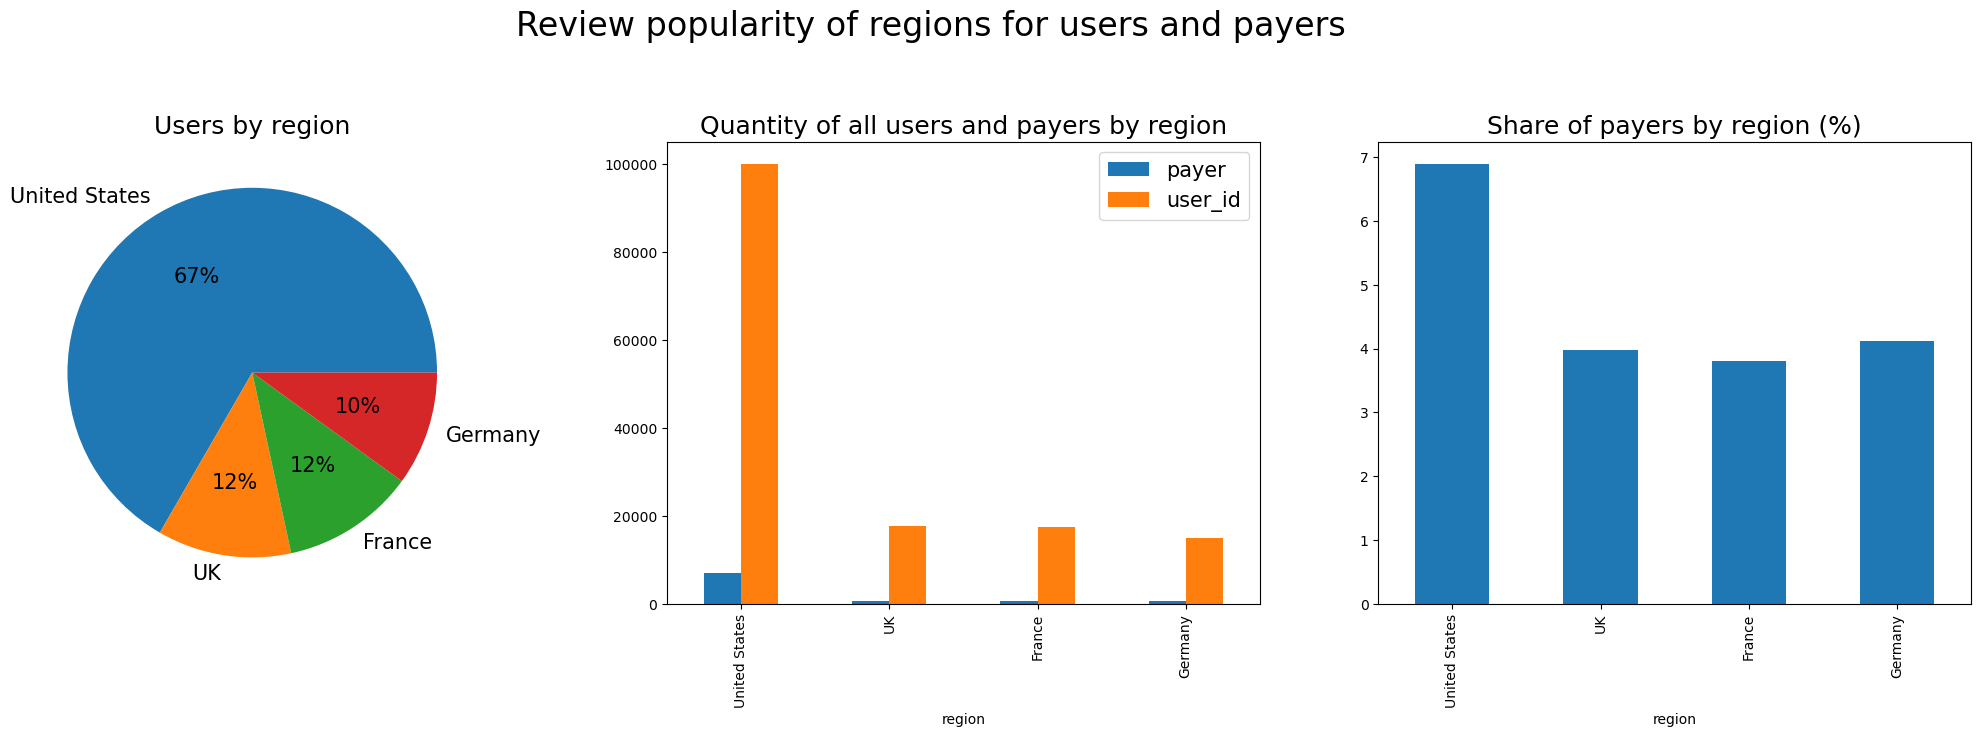

,payer,user_id,payer_share%
region,,,
United States,6902,100002,6.901862
UK,700,17575,3.982930
France,663,17450,3.799427
Germany,616,14981,4.111875


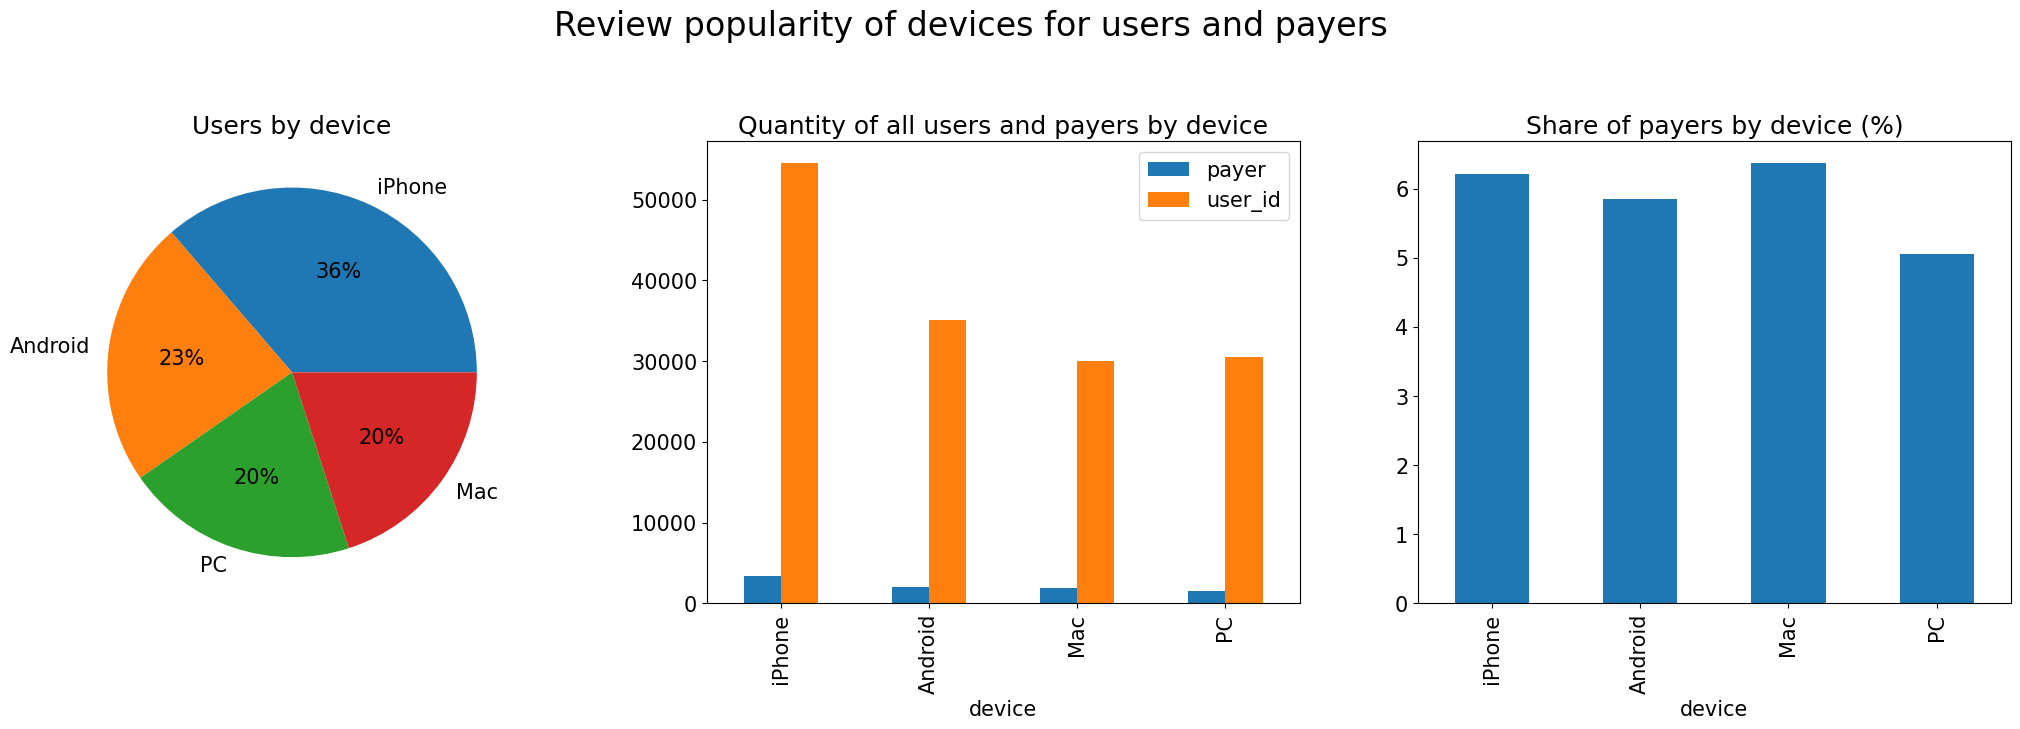

,payer,user_id,payer_share%
device,,,
iPhone,3382,54479,6.207897
Android,2050,35032,5.851793
Mac,1912,30042,6.364423
PC,1537,30455,5.046790


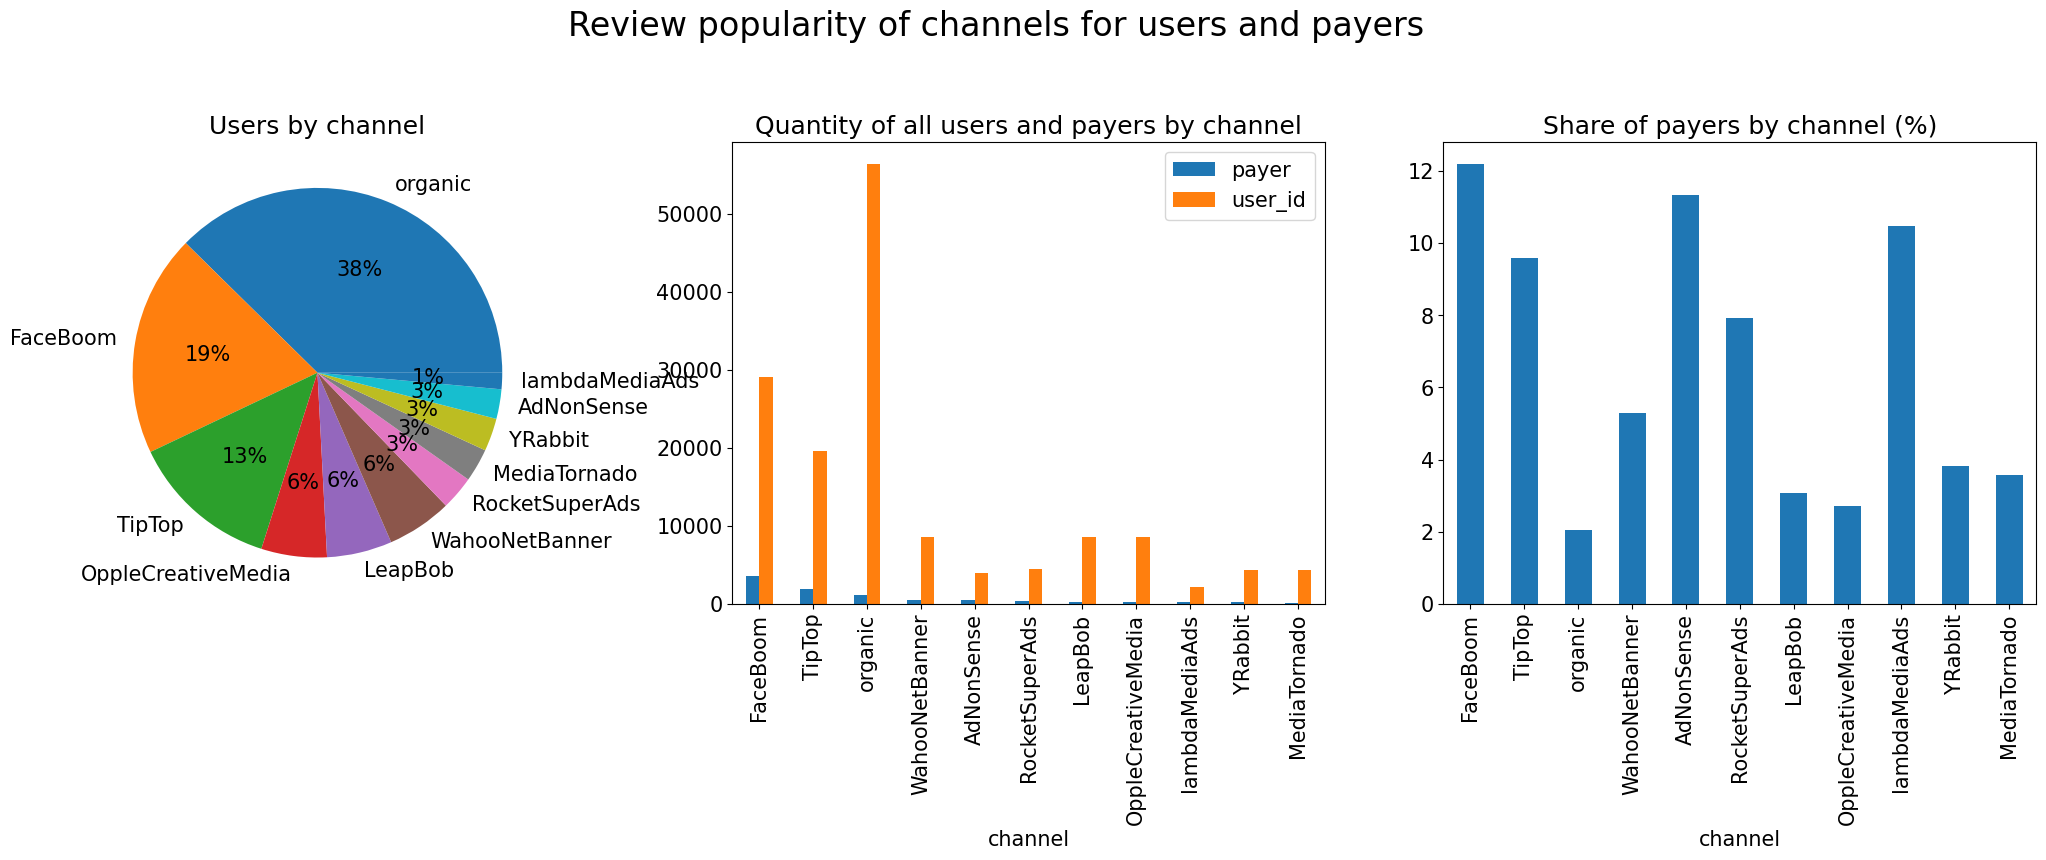

,payer,user_id,payer_share%
channel,,,
FaceBoom,3557,29144,12.204914
TipTop,1878,19561,9.600736
organic,1160,56439,2.055316
WahooNetBanner,453,8553,5.296387
AdNonSense,440,3880,11.340206
RocketSuperAds,352,4448,7.913669
LeapBob,262,8553,3.063253
OppleCreativeMedia,233,8605,2.707728
lambdaMediaAds,225,2149,10.469986


In [20]:
# поскольку для разных критериев прийдется выполнить одни и те же опереции, повторю их в цикле:

characteristics = ['region','device','channel']  #список критериев 

for char in characteristics:
    payers_share = profiles.pivot_table(
    index= char,  
    values=['payer','user_id'], 
    aggfunc={'user_id':'count','payer':'sum'}
).sort_values(by='payer',ascending=False)        #сводная таблица с необходимыми столбцами 
    
    fig, (ax0,ax1,ax2) = plt.subplots(nrows=1,ncols=3,figsize=(26,6))
    plt.rc('font', size= 15)                     
    
    fig. suptitle(f'Review popularity of {char}s for users and payers',y=1.1,fontsize = 24)
    
    profiles[char].value_counts()\
    .plot(kind='pie',ylabel = '', autopct='%.0f%%', title=f'Users by {char}',ax=ax0)
    ax0.set(ylabel='')
    
    payers_share.plot(kind='bar', title=f'Quantity of all users and payers by {char}',ax=ax1)
    ax1.set(ylabel='')
    
    payers_share['payer_share%'] = payers_share.payer / payers_share.user_id * 100
    
    payers_share['payer_share%'].plot(kind='bar', title=f'Share of payers by {char} (%)',ax=ax2)
    ax2.set(ylabel='')
    
    plt.show()
    
    display(payers_share)    
    # отображу и исходные таблицы, поскольку это указано в задании, 
    #а как указать значения столбцов на барплотах я не смог разобраться
    print()
    print()


**Вывод**

Пользавателями приложения стали жители США, Великоблитании, Франции и Германии, причем доля США - 67%, по 12% для Великоблитании и Франции и 10% для Германии. Доли платящих пользователей для каждой из стран составили 6.9, 3.98, 3.78 и 4.11 процентов соответственно.Наибольшее число платящих пользователей (6902) из США, их число почти в 3.5 раза превышает число всех платящих пользователей из других стран. 

Самым популярным устройством для установки приложения является iPhone - его используют 36% пользователей приложения, Android используют 23% пользователей и по 20% пользователей PC и Mac. При этом для каждой из платформ число платящих пользователей составляет около 5-6 процентов. 


Наиболее крупными источниками привлечения пользователей являются - organic, FaceBoom и TipTop - доли привлеченных пользователей для этих каналов составляют 39, 19 и 13 процентов соответственно.  Однако только 2% organic пользователей платят,  а больше всего больше всего платящих пользователей были привлечены через каналы FaceBoom и TipTop.

### Оценка расходов на маркетинг<a id="chapter4"></a>

#### Динамика изменения расходов  по каждому каналу <a id="section_4_1"></a>

Посчитаю общую сумму расходов на маркетинг:

In [21]:
total_costs = round(costs.costs.sum(),2)
print('Общая суммa расходов на маркетинг :', total_costs)

Общая суммa расходов на маркетинг : 105497.3


Выясню, как траты распределены по рекламным источникам, для этого просуммирую расходы, сгруппировав данные по каналам: 

In [22]:
costs_by_channel = costs.pivot_table(
    index= 'channel',  
    values='costs', 
    aggfunc='sum'
).sort_values(by='costs',ascending=False).reset_index()
costs_by_channel['perc']=costs_by_channel['costs']/total_costs
costs_by_channel

,channel,costs,perc
0,TipTop,54751.30,0.518983
1,FaceBoom,32445.60,0.307549
2,WahooNetBanner,5151.00,0.048826
3,AdNonSense,3911.25,0.037074
4,OppleCreativeMedia,2151.25,0.020392
5,RocketSuperAds,1833.00,0.017375
6,LeapBob,1797.60,0.017039
7,lambdaMediaAds,1557.60,0.014764
8,MediaTornado,954.48,0.009047
9,YRabbit,944.22,0.008950


#### Динамика изменения расходов  по каждому каналу <a id="section_4_2"></a>

Визуализирую динамику изменения расходов во времени (по неделям и месяцам) по каждому источнику:

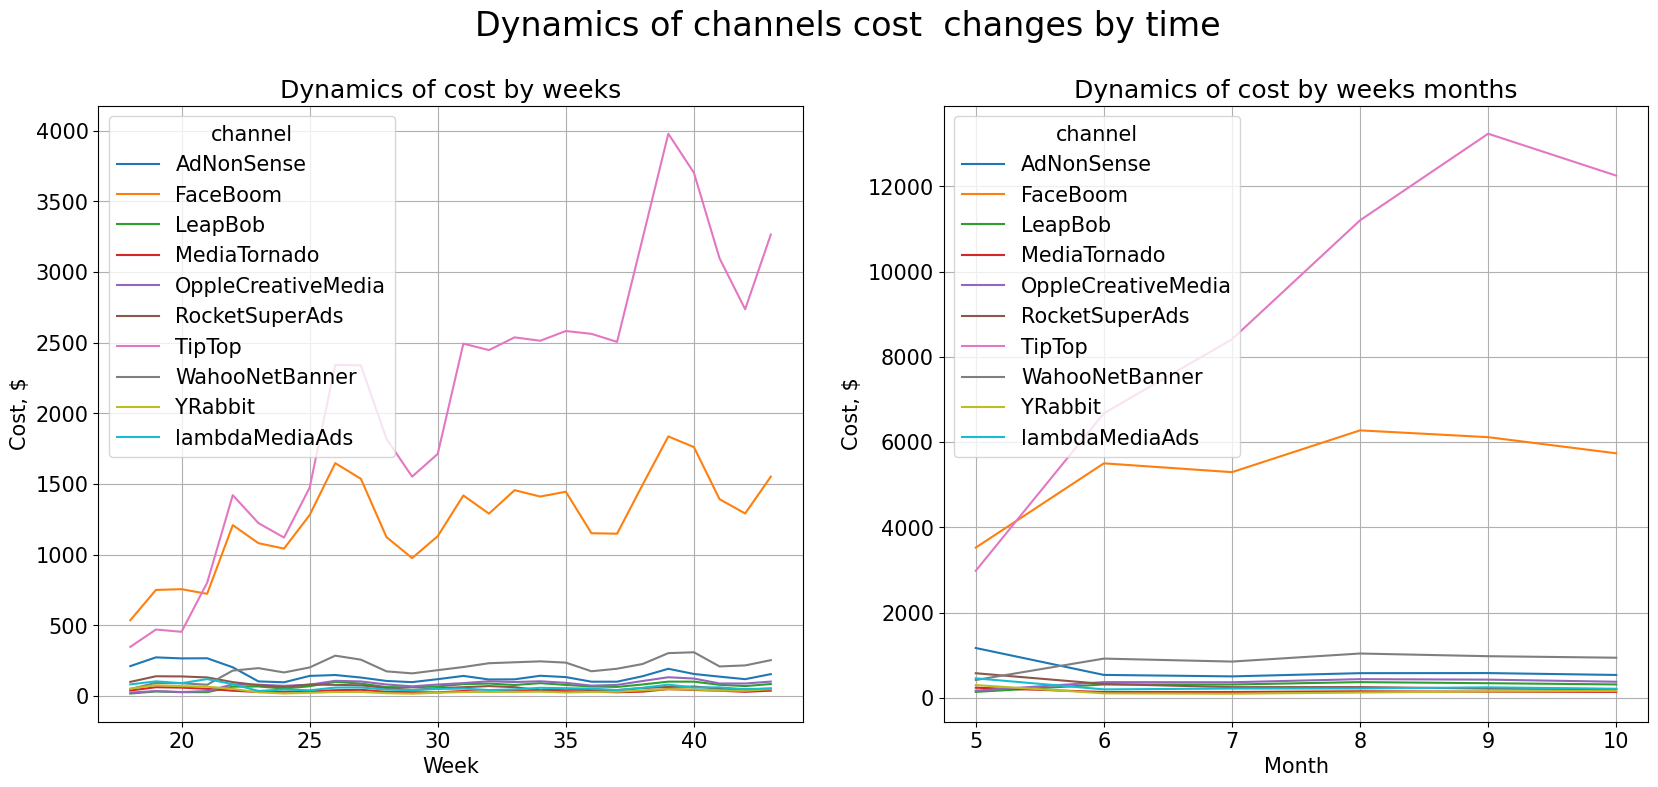

In [23]:
# выделю номера недель и месяцов в отдельные столбцы
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
costs['month'] = pd.to_datetime(costs['dt']).dt.month

# построю графики суммы расходов по каждому каналу сгруппировав данные по неделям и месяцам
plt.figure(figsize=(20, 8))
plt. suptitle('Dynamics of channels cost  changes by time',y=1,fontsize = 24)
costs.pivot_table(index='week',
                  columns='channel',
                  values='costs',
                  aggfunc='sum').plot(grid=True, ax=plt.subplot(1, 2, 1))
                                      
plt.title('Dynamics of cost by weeks')
plt.xlabel('Week')
plt.ylabel('Cost, $')
 
costs.pivot_table(index='month',
                  columns='channel',
                  values='costs',
                  aggfunc='sum').plot(grid=True, ax=plt.subplot(1, 2, 2))
                                      
plt.title('Dynamics of cost by weeks months')
plt.xlabel('Month')
plt.ylabel('Cost, $')
plt.show();

#### Среднее значение CAC для каждого канала рекламы<a id="section_4_3"></a>

Вычислю, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника:

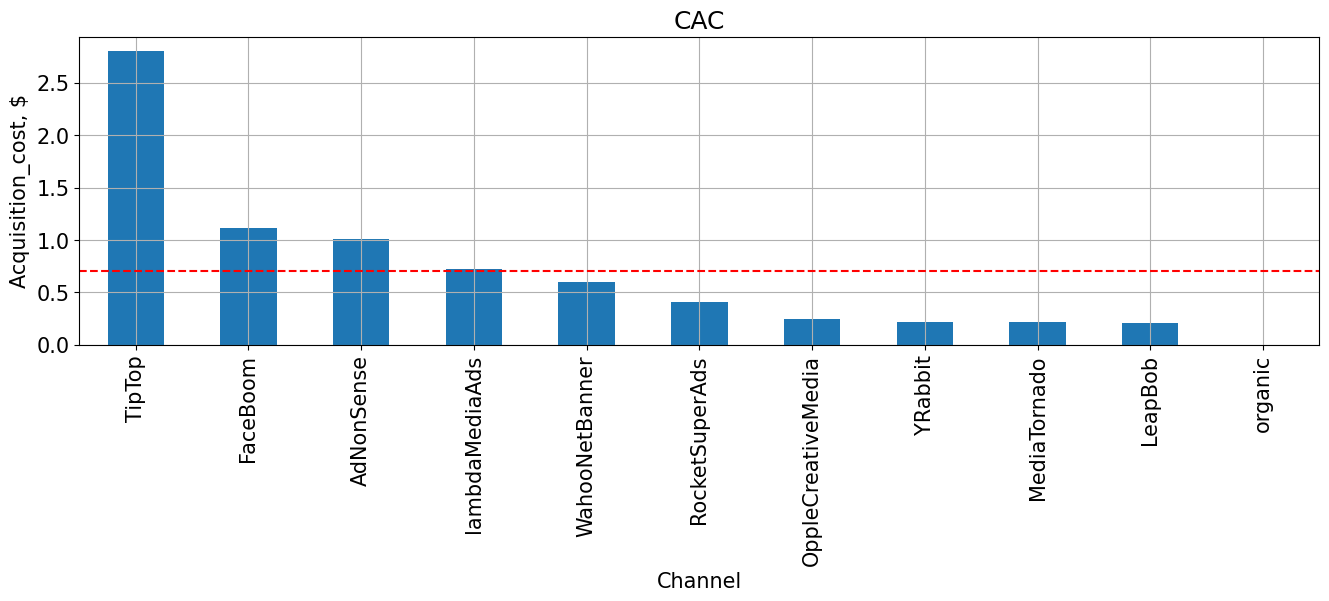

In [24]:
profiles.pivot_table(index='channel',
                  values='acquisition_cost',
                  aggfunc='mean').sort_values(by='acquisition_cost',ascending=False)\
.plot(kind='bar',y='acquisition_cost',legend=False, title='CAC',figsize=(16, 4),grid=True)
plt.xlabel('Channel')
plt.ylabel('Acquisition_cost, $')
plt.axhline(y=profiles.acquisition_cost.mean(),#среднее значение  CAC
             color='red', linestyle='--', label='Среднее значение CAC');

**Вывод**

Общая сумм расходов на маркетинг составила 105497.3 $. Более 50% этой суммы потрачено на рекламу через канал TipTop, 30% на рекламу через FaceBoom.

Визуализация динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику показывает, что расходы на рекламу подвержены сезональности, с явными пиками на 26 и 39 неделях, но для канала TipTop расходы на рекламу были дополнительно увеличены с 30й недели. 

В среднем привлечение одного пользователя было самым дорогим для канала TipTop: в два и более раза дороже чем для других каналов, расходы на рекламу через FaceBoom и AdNoneSense также выше среднего значения. 



### Оценка окупаемости рекламы<a id="chapter5"></a>

#### Анализ окупаемости рекламы c помощью графиков LTV и ROI<a id="section_5_1"></a>

Установлю момент и горизонт анализа данных. Буду считать, что на календаре 1 ноября 2019 года, и задам горизонт анализа в две недели:

In [25]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14 

Отфильтрую organic пользовательзователей, поскольку их привлечение было бесплатным. 

In [26]:
profiles = profiles.query('channel != "organic"')

Оценю общую ситуацию — проверю окупаемость рекламы. Рассчитаю и визуализирую LTV и ROI, вызвав функции get_ltv() и plot_ltv_roi():

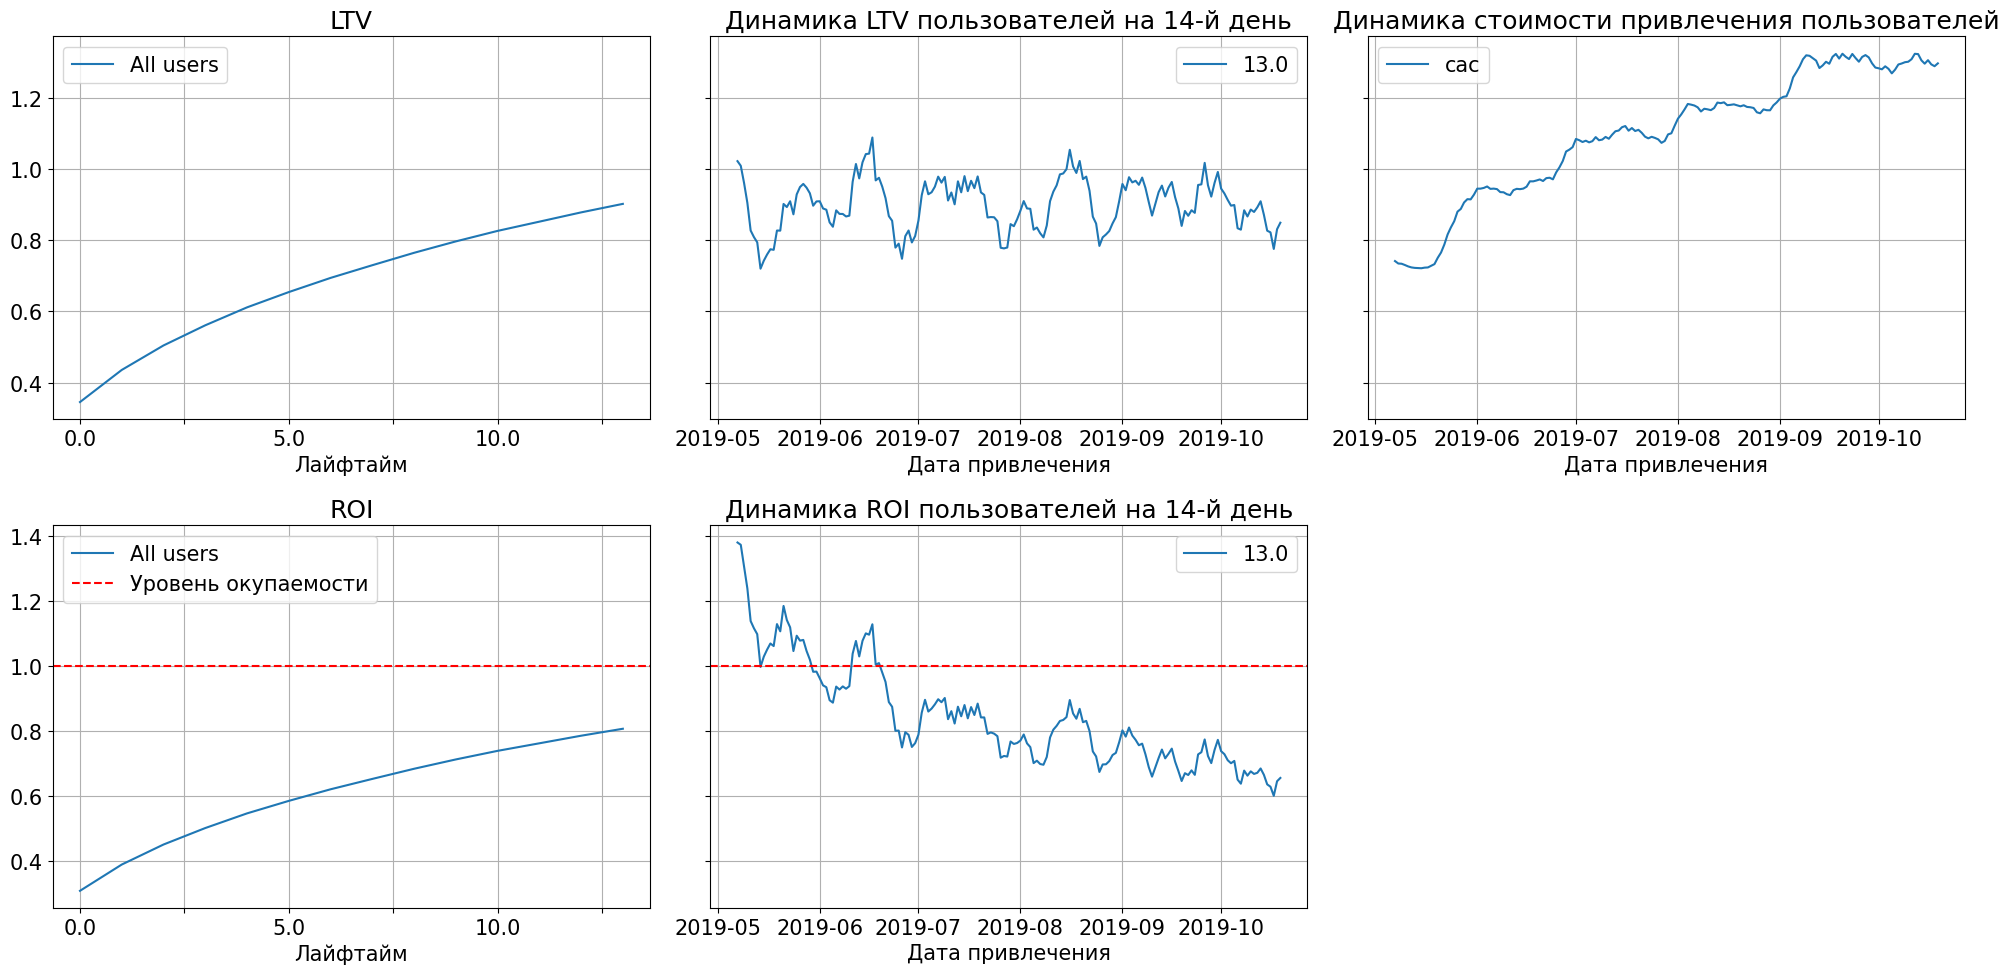

In [27]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать такие выводы:
- На LTV влияет сезонный фактор, но в целом этот показатель достаточно стабилен, значит, дело не в ухудшении качества пользователей.
- Реклама не окупается. ROI в конце недели — чуть выше 80%, при этом на графике динамики ROI видно что первый и частично второй месяц всё же были прибыльными.  
- CAC с середины первого месяца стал стал стремительно увеличиваться. Скорее всего 
это и стало причиной низкого ROI в итоге.


Чтобы выявить причины неокупаемости рекламы, необходимо проанализировать окупаемость с разбивкой по различным параметрам.

#### Анализ окупаемости рекламы с разбивкой по устройствам<a id="section_5_2"></a>

Проверю окупаемость по устройсвам : передам параметру dimensions столбец deviсe.

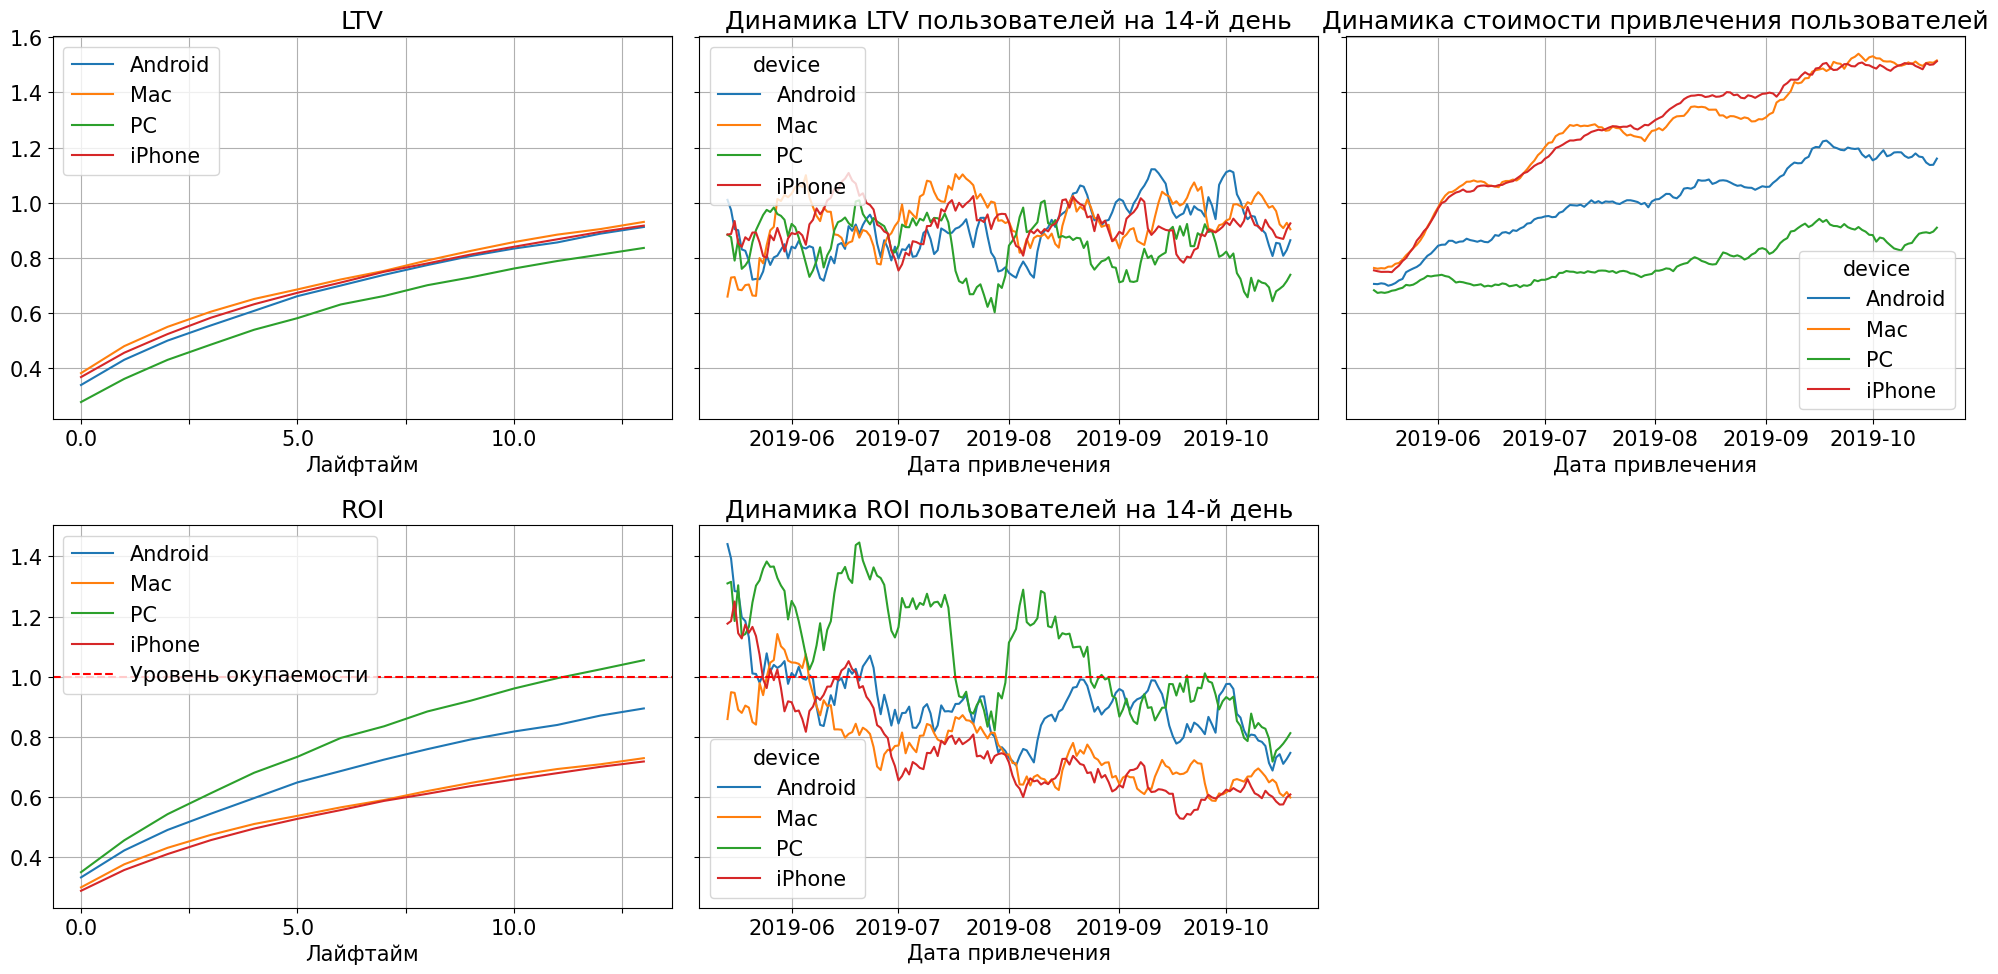

In [28]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Только пользователи PC окупаюстся, причем из графиков динамики CAC и ROI видно, что даже для пользователи PC после увеличения CAC в сентябре перестали окупаться.

А хуже всего себя показывают пользователю Iphone и  Mac, LTV этих пользователей незначительно выше, но CAC сильно превосходит другие платформы. 


Проверю как пользователи платформ распределены по регионам:

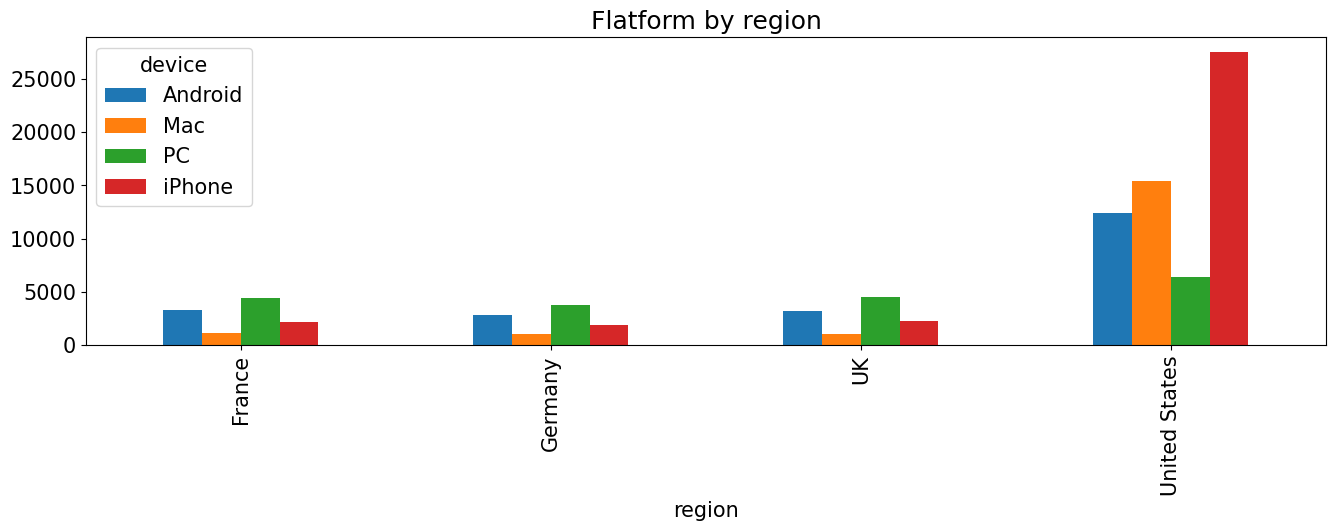

In [29]:
profiles.pivot_table(
    index= 'region',
    columns='device',
    values='user_id', 
    aggfunc='count'
).plot(kind='bar',title='Flatform by region',figsize=(16,4));

Количество пользователей Iphone и Mac на порядок выше в США чем в других странах, необходимо проверить окупаемость в разрезе стран.

#### Анализ окупаемости рекламы с разбивкой по странам<a id="section_5_3"></a>

Проверю окупаемость по странам : передам параметру dimensions столбец region.

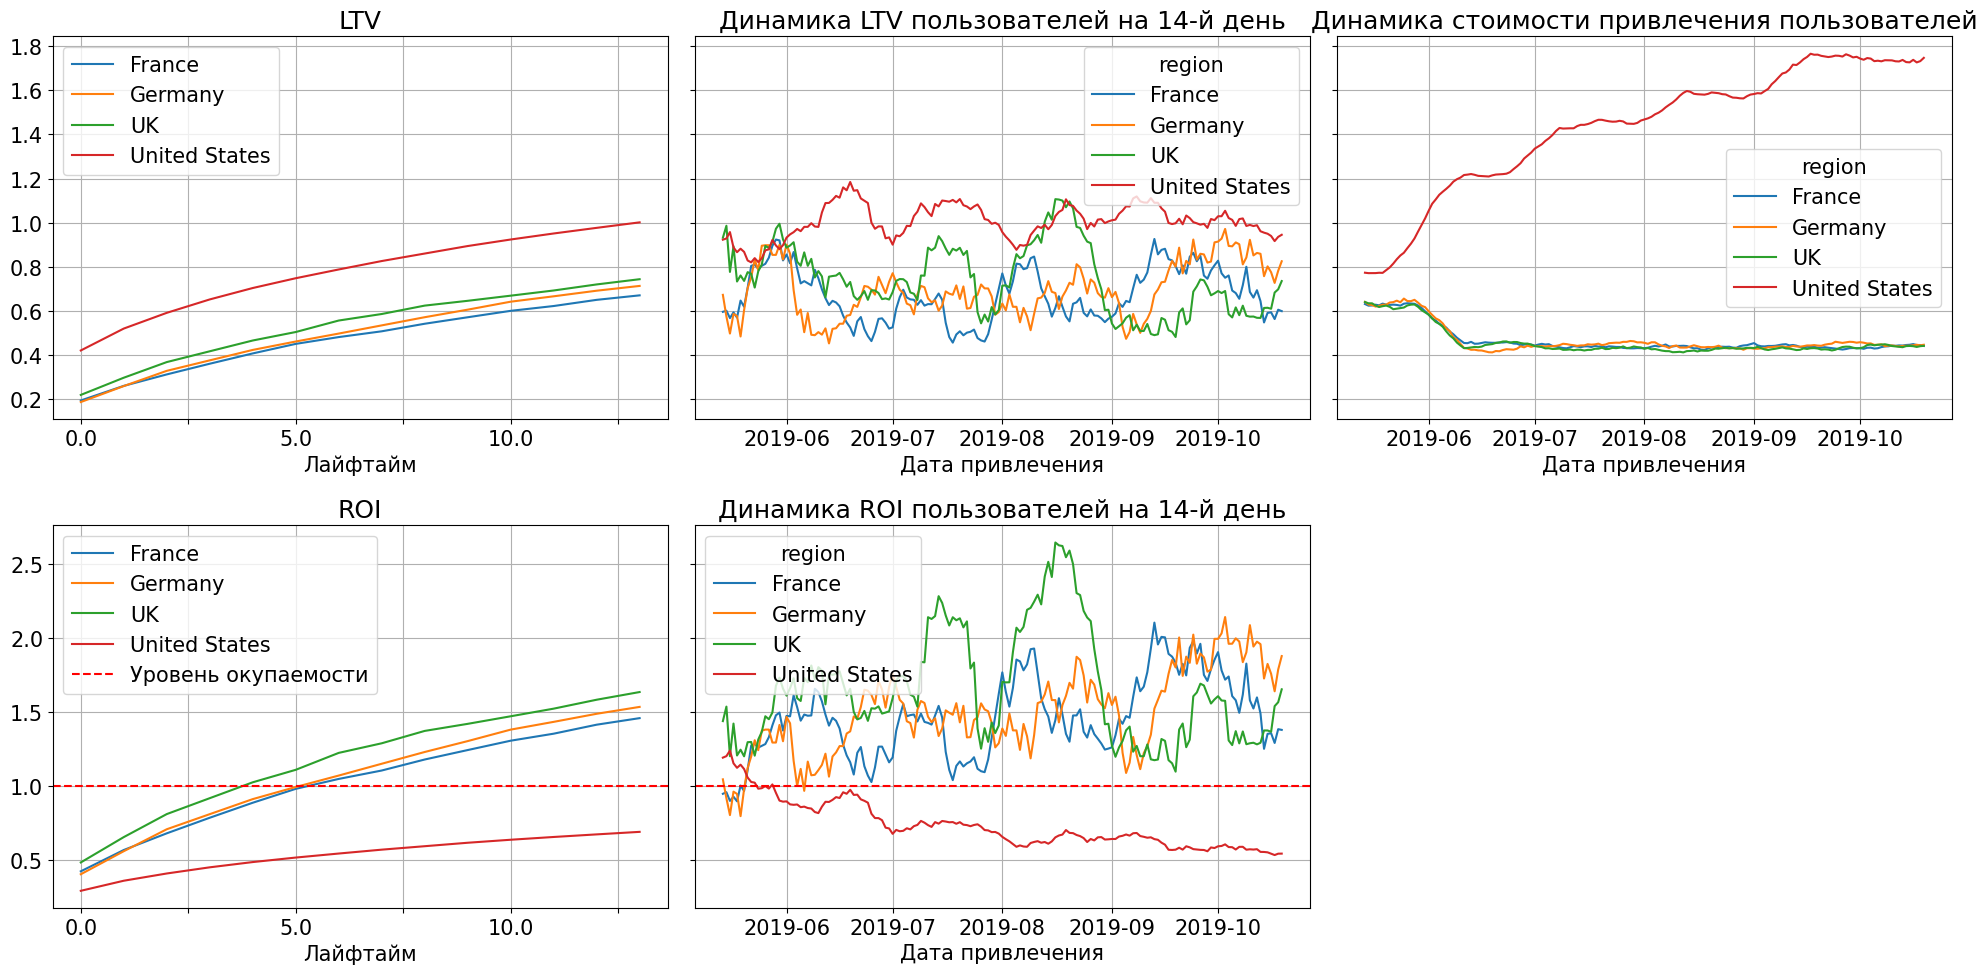

In [30]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Разбивка по странам показала:

- LTV всё так же подвержен сезонности, но стабилен. Сезонность LTV возможно связана с периодами рекламных акций, либо на сезонность влияет специфика приложения.
- Стоимость привлечения стабильна и одинакова для всех стран, кроме США, где CAC значительно выше и растет. 
- Реклама не окупается в регионе США, причем явно видно что проблемы начались с момента увеличинеия расходов на рекламу в конце мая.


Чтобы детальнее разобраться в причинах неокупаемости рекламы в США проверю  окупаемость рекламы с разбивкой по источникам, но прежде проверю как пользователи привлеченные из различных источников распределены по странам:

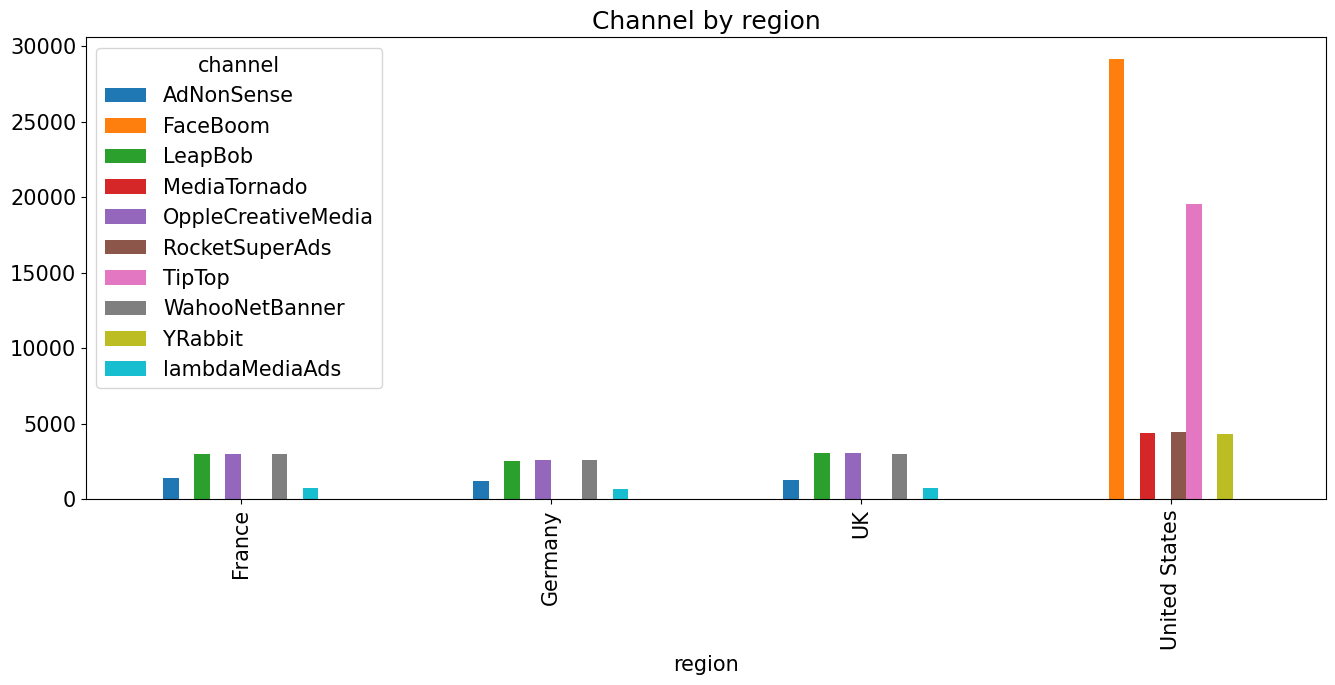

In [31]:
profiles.pivot_table(
    index= 'region',
    columns='channel',
    values='user_id', 
    aggfunc='count'
).plot(kind='bar',title='Channel by region',figsize=(16,6));

Пользователи из Европы и США привлекаются по средством разных рекламных каналов! 

Выше было выявлено что проблема с окупаемостью присутствует для США, поэтому поспротрю окупаемость по каналам только для США:

In [32]:
profiles_us= profiles.query('region == "United States"')

#### Анализ окупаемости рекламы с разбивкой по рекламным каналам<a id="section_5_4"></a>

Проверю источники привлечения (channel). Возможно, на окупаемость влияет неудачная реклама в каком-нибудь одном канале.

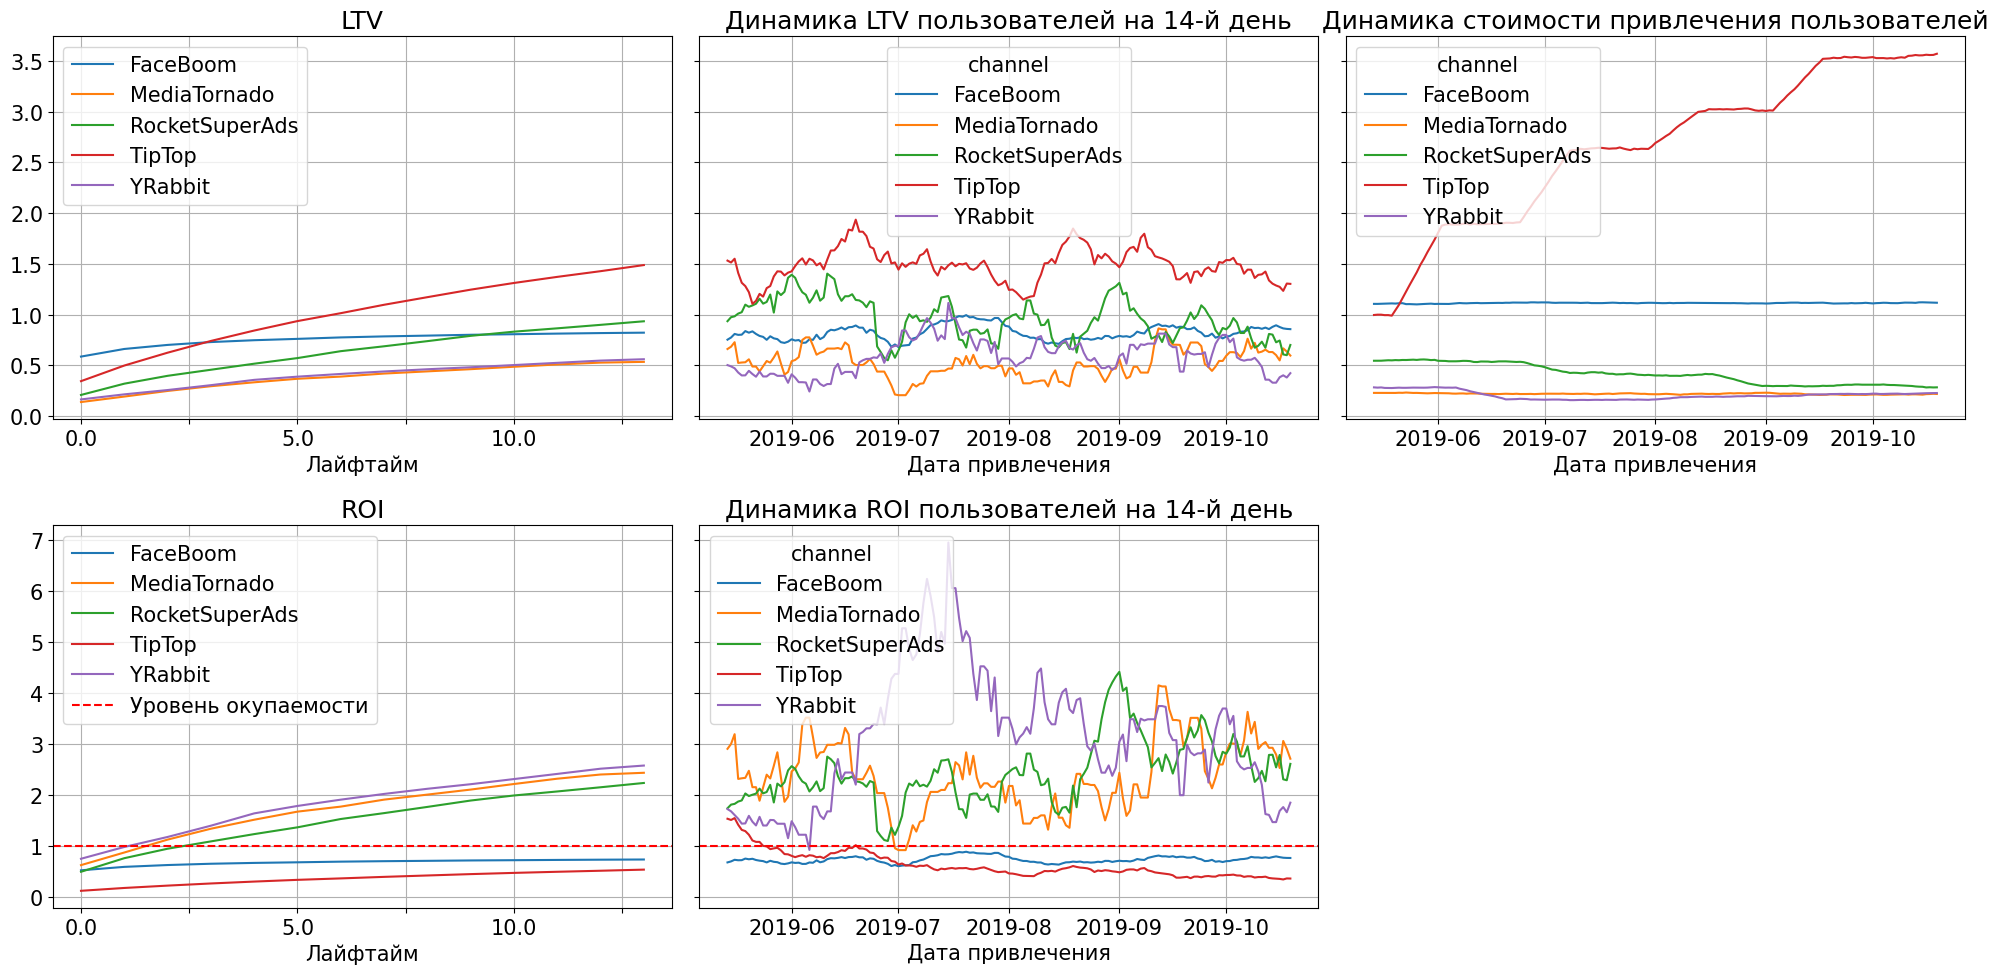

In [33]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_us, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Графики разбивки по каналам показали, что в США реклама на TipTop и FaceBoom стабильно не окупается,а стоимость привлечения пользователей для этих каналов значительно выше чем для других.Причем не смотря на то, что CAC для канала TipTop постоянно растет, ROI для FaceBoom все равно выше чем для TipTop,хотя CAC для этого канала стабилен. 

Важно отметить, что другие каналы рекламы(YRabbit, MediaTornado, RocketSupperAds) при низких CAC, показывают высокий уровень ROI, особенно канал YRabbit.

Проверю в чём причина: в низкой конверсии или низком удержании.

#### Анализ конверсии и удержания пользователей<a id="section_5_5"></a>

Анализ окупаемости рекламы показал, что есть явные проблемы с рекламой в США. Проверю конверсию и удержание для пользователей разных стран: 

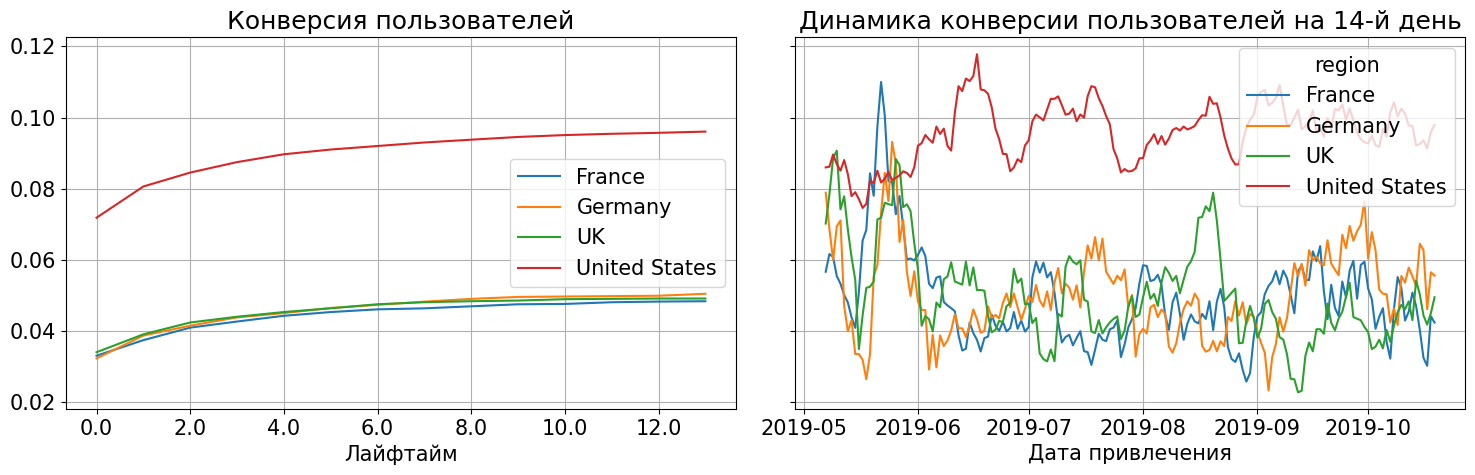

In [34]:
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days,dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Проверю удержание и динамику удержания для платящих и неплатищих пользователей:

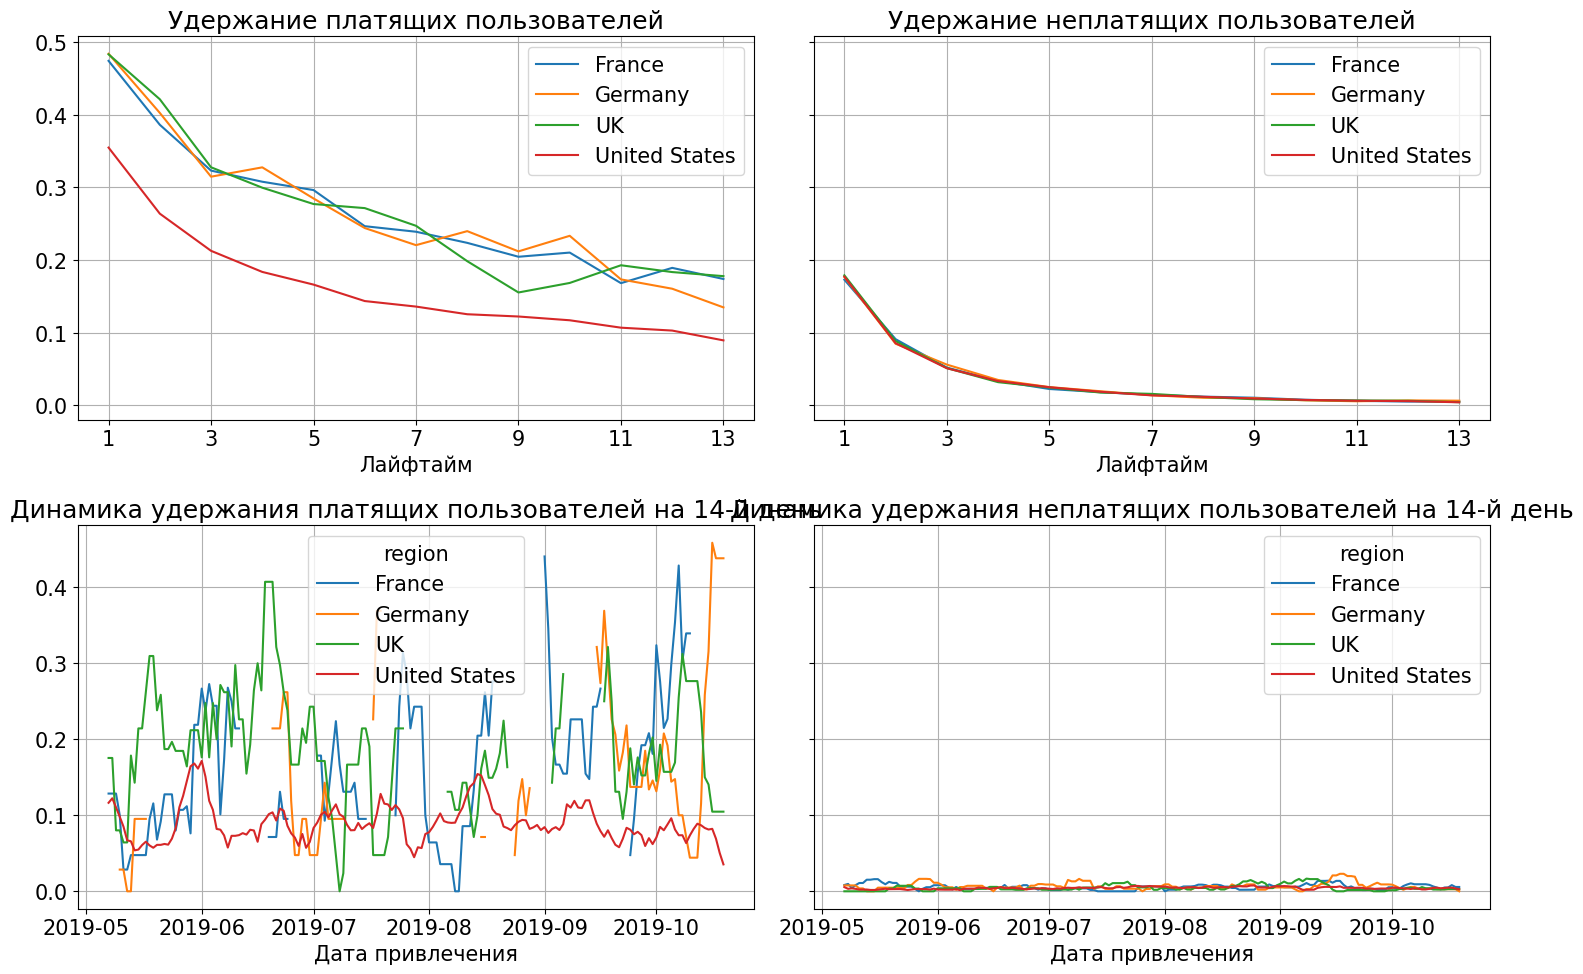

In [35]:
dimensions = ['region']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days,dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Конверсия для США выше чем у других стран, а вот с удержанинем пользователей явные проблемы.

Проверю конверсию и удержание для пользователей США в разрезе источников рекламы:

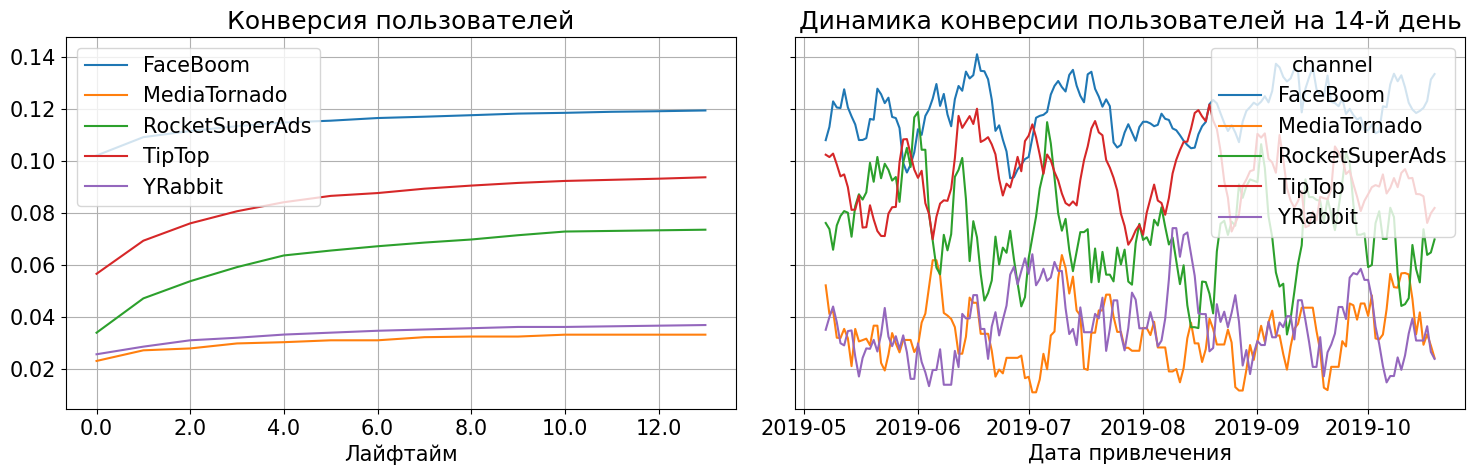

In [36]:
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_us, orders, observation_date, horizon_days,dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

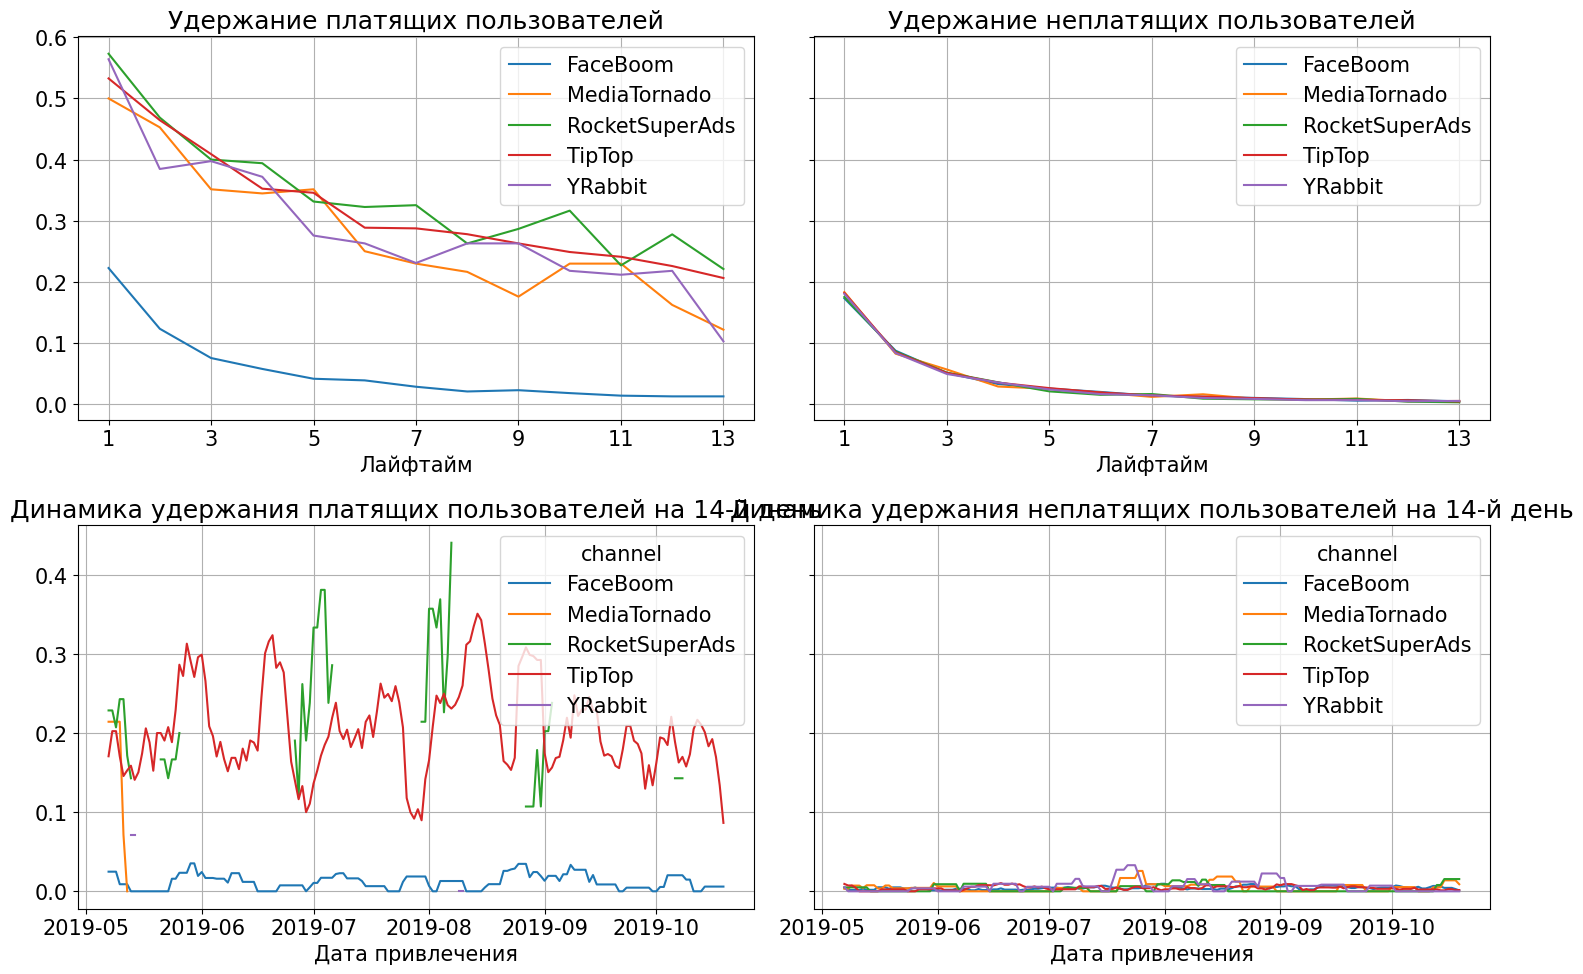

In [37]:
dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_us, visits, observation_date, horizon_days,dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Анализ конверсии и удержания по каналам показал, что конверсия для самых нерентабельных каналов (TipTop и FaceBoom) самая высокая, но  удержание, для  канал Faceoom значительно ниже других каналов.

**Вывод**

Анализ графиков  LTV, ROI и CACпоказал, что реклама, направленная на привлечение пользователей в целом не окупается. ROI в конце недели — чуть выше 80%. LTV всё так же подвержен сезонности, но стабилен.

Стоимость привлечения пользователей стабильна и одинакова для всех стран, кроме США, где CAC значительно выше и растет. Выявлены проблемы с окупаемостью в США, причиной чего является низкое удержанинем пользователей.

Графики разбивки по каналам показали, что в США реклама на TipTop и FaceBoom стабильно не окупается,а стоимость привлечения пользователей для этих каналов значительно выше чем для других нет. Другие каналы рекламы(YRabbit, MediaTornado, RocketSupperAds) при низких CAC, показывают высокий уровень ROI, особенно канал YRabbit.

Анализ конверсии и удержания по каналам показал, что конверсия для самых нерентабельных каналов (TipTop и FaceBoom) самая высокая, но удержание, для канал Faceoom значительно ниже других каналов.

### Выводы и рекомендации<a id="chapter6"></a>

Для развлекательного приложения Procrastinate Pro+ было необходимо выявить причины неокпаемости вложений в рекламу и убытков последних месяцев.

Для анализа были предоставлены данные о визитах, заказах и рекламных расходах приложения.

Данные были изучены, выполнена предобработка.
Пропусков и дубликатов в данных не было обнаружено. В необходимых столбцах  были изменены типы данных, название столбцов были приведены к нижнему регистру, неявных дубликатов в столбцах с категориальными данными обнаружено не было.

В рамках исследовательского анализа данныех было установлено, что пользавателями приложения являются жители США, Великоблитании, Франции и Германии, причем доля США - 67%, по 12% для Великоблитании и Франции и 10% для Германии. Наибольшее число платящих пользователей (6902) из США, их число почти в 3.5 раза превышает число всех платящих пользователей из других стран. Доли платящих пользователей для каждой из стран составили 6.9, 3.98, 3.78 и 4.11 процентов соответственно.

Самым популярным устройством для установки приложения является iPhone - его используют 36% пользователей приложения, Android используют 23% пользователей и по 20% пользователей PC и Mac. При этом для каждой из платформ число платящих пользователей составляет около 5-6 процентов.

Наиболее крупными источниками привлечения пользователей являются - organic, FaceBoom и TipTop - доли привлеченных пользователей для этих каналов составляют 39, 19 и 13 процентов соответственно. Однако только 2% organic пользователей платят, а больше всего больше всего платящих пользователей были привлечены через каналы FaceBoom и TipTop.

Была произведена оценка расходов на маркетинг: - общая сумма расходов на маркетинг составила 105497.3 $. Более 50% этой суммы потрачено на рекламу через канал TipTop, 30% на рекламу через FaceBoom.

Была проанализирована стоимость привлечения одного пользователя по каналам: - 
в среднем привлечение одного пользователя было самым дорогим для канала TipTop (в два и более раза дороже чем для других каналов).

Анализ окупаемости рекламы показал, что реклама, направленная на привлечение пользователей в целом не окупается. ROI в конце недели — чуть выше 80%. LTV подвержен сезонности, но стабилен.

Стоимость привлечения пользователей стабильна и одинакова для всех стран, кроме США, где CAC значительно выше. Реклама не окупается в регионе США, причем проблемы начались с момента увеличинеия расходов на рекламу в конце мая.

Графики окупаемости с разбивкой по каналам для США показал, что реклама на TipTop и FaceBoom стабильно не окупается,а стоимость привлечения для канала TipTop значительно выше чем для других. 
Важно отметить, что другие каналы рекламы(YRabbit, MediaTornado, RocketSupperAds) при низких CAC, показывают высокий уровень ROI, особенно канал YRabbit.

Анализ конверсии и удержания каналов рекламы в США показал, что конверсия для самых нерентабельных каналов (TipTop и FaceBoom) самая высокая, но удержание, для канал Faceoom значительно ниже других каналов.


**Рекомендации:**

Основные причины неокупаемости вложений в рекламу приложения и убытков последних месяцев  связаны с неэффективным распределение рекламного бюджета среди каналов рекламы на рынке США.
 
 Для достижения положительного ROI необходимо:
 
 - Cократить расходы на рекламу через канал TipTop, либо отказаться от этого источника в пользу каналов YRabbit, MediaTornado или RocketSupperAds - при сходных с другими каналами показателях удержания и конверсии канал TipTop имеет слишком высокий CAC.
 - Отказаться рекламы через канал FaceBoom в пользу каналов YRabbit, MediaTornado или RocketSupperAds - при достаточно высоком CAC, канал FaceBoom показывает слишком низкий уровень удержания.